# Respiratory Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the respiratory rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.
    
    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate the respiratory rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    
4. Metrics:

    4.1. Respiratory Rate Per Minute (RPM): extrapolate RPM, and make an histogram of the result. Does it follow a particular distribution?

    4.2. Respiratory Rate Variability (RRV): extrapolate RRV, explain why this parameter is important, and plot the results.


5. **Optional**: Elaborate a simple algorithm to extrapolate the respiratory rate even when the filter fails (e.g. look for a particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 Analysis of center_sternum.txt

## 1.1 Data preparation

### 1.1.1 Load the raw data and select columns

In [2]:
df = pd.read_csv('center_sternum.txt', delimiter = "\t")
df = df[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']]
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...
16501,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


### 1.1.2 Plot selected data and choose a proper time window 

First and last 10 seconds are very nosy, so we removed those data from the dataset

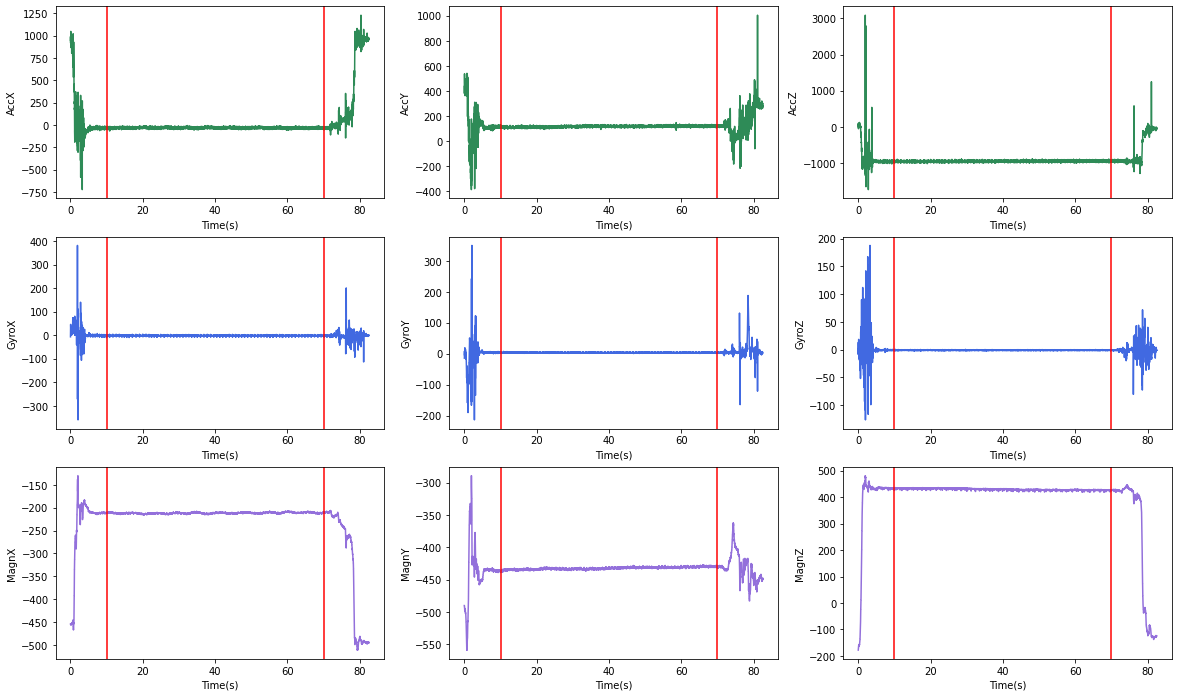

In [3]:
freq = 200
x = np.linspace(0, df.shape[0] / freq, df.shape[0])

y_label = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
color = ['seagreen', 'seagreen', 'seagreen', 'royalblue', 'royalblue', 'royalblue', 'mediumpurple', 'mediumpurple', 'mediumpurple']

fig, axs = plt.subplots(3, 3, figsize = (20, 12))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df[y_label[i]], color = color[i])
    ax.axvline(x = 10, color = 'r')
    ax.axvline(x = 70, color = 'r')
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    

#### Meaningful data

In [4]:
df2 = df.iloc[2000:14000, :].copy()
x = np.linspace(0, 60, 12000)
df2

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,-32.635,112.911,-953.796,1.755725,5.022901,-0.809160,-212,-439,432
2001,-19.154,112.362,-971.608,1.557252,4.198473,-1.083969,-212,-439,432
2002,-27.450,110.593,-944.280,0.931298,4.320611,-1.099237,-211,-436,428
2003,-21.777,113.948,-940.803,0.946565,4.137404,-1.267176,-211,-436,428
2004,-32.391,118.218,-924.394,1.022901,4.702290,-0.992366,-212,-438,433
...,...,...,...,...,...,...,...,...,...
13995,-36.478,113.582,-936.777,-3.145038,3.465649,-0.610687,-211,-431,427
13996,-30.866,118.767,-941.108,-3.175573,3.358779,-0.778626,-210,-430,427
13997,-32.818,118.279,-942.145,-2.992366,3.679389,-0.549618,-210,-430,427
13998,-22.692,113.704,-948.184,-3.022901,3.786260,-0.564885,-211,-432,427


### 1.1.3 Calibration

In [5]:
gyro_offset = np.array([-2.242224,2.963463,-0.718397])

acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])

magn_cal = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset = np.array([-95.67974,-244.9142,17.71132])

df2[['GyroX','GyroY','GyroZ']] = df2[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df2[['AccX','AccY','AccZ']] = np.dot(df2[['AccX','AccY','AccZ']],acc_cal.T) + acc_offset.T
df2[['MagnX','MagnY','MagnZ']] = np.dot(df2[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_offset.T

### 1.1.4 Plot meaningful data

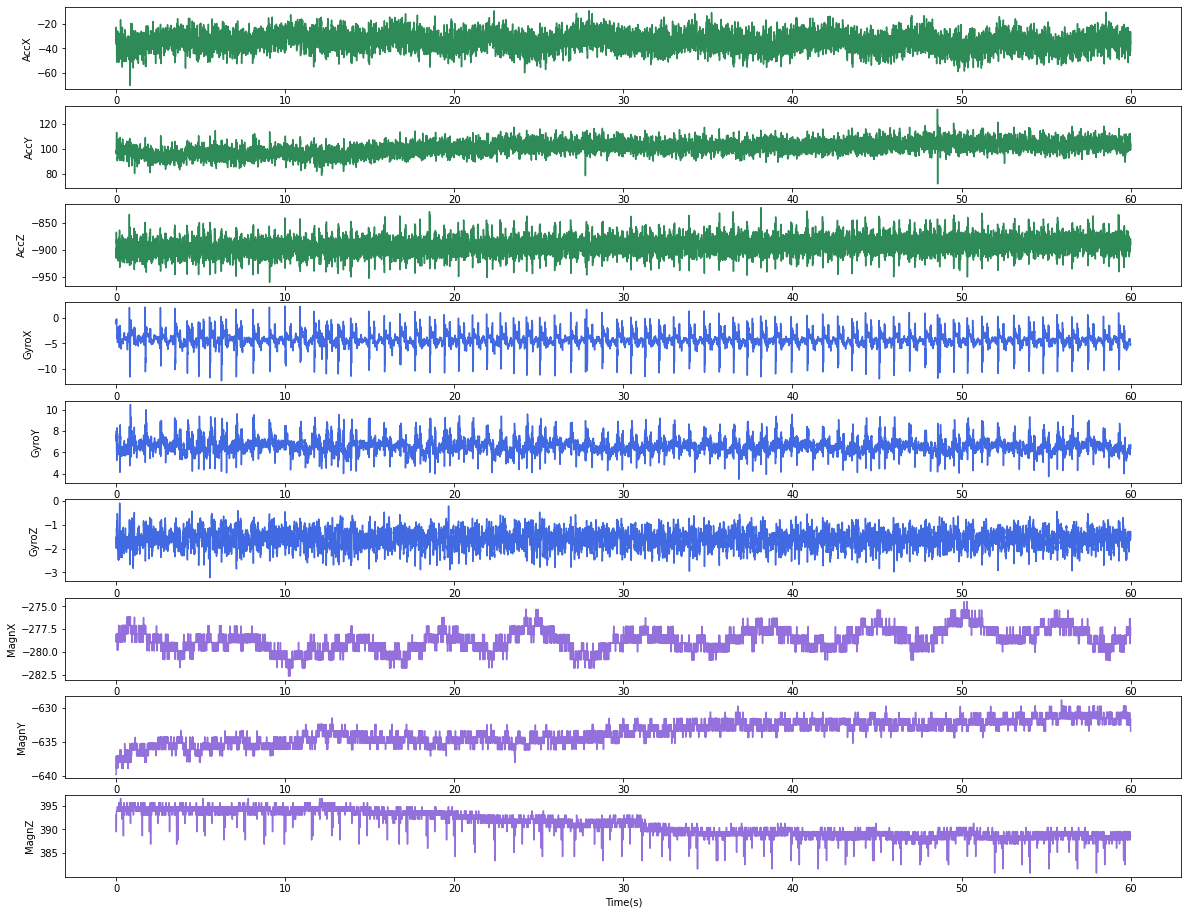

In [6]:
fig, axs = plt.subplots(9, 1, figsize = (20, 16))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df2[y_label[i]], color = color[i])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])

## 1.2 Time and frequency analysis
### 1.2.1 Statistical analysis
#### Mean, median, variance, standard deviation, 25th and 75th percentiles

In [7]:
stat = pd.DataFrame({'Mean': df2.mean(), 'Median': df2.median(), 'Variance': df2.var(), 'Standard deviation': df2.std(),
    '25% percentile': df2.quantile(q = 0.25), '75% percentile': df2.quantile(q = 0.75)})
stat

,Mean,Median,Variance,Standard deviation,25% percentile,75% percentile
AccX,-34.234293,-34.158425,49.260255,7.018565,-38.854045,-29.560357
AccY,100.900265,101.068429,27.191455,5.214543,97.480937,104.345627
AccZ,-892.401054,-892.838259,208.983725,14.456269,-900.970347,-884.565100
GyroX,-4.326728,-4.394896,1.996583,1.413005,-4.929247,-3.723140
GyroY,6.646299,6.597051,0.507940,0.712699,6.245906,6.963463
GyroZ,-1.587087,-1.573359,0.131751,0.362975,-1.817634,-1.344351
MagnX,-278.667645,-278.966269,1.470737,1.212739,-279.106893,-278.050465
MagnY,-633.583895,-633.408090,2.762531,1.662086,-635.170051,-632.474220
MagnZ,391.063967,390.435310,6.520047,2.553438,388.688414,393.902779


#### Correlation coefficients

In [8]:
df2_corr = df2.corr()
df2_corr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.180828,-0.412005,0.203288,0.010442,0.025054,-0.386831,-0.051802,0.087693
AccY,-0.180828,1.000000,0.165032,-0.050947,-0.011371,-0.133083,0.243585,0.358844,-0.490141
AccZ,-0.412005,0.165032,1.000000,-0.079125,0.112730,0.025872,0.123488,0.190235,-0.236575
GyroX,0.203288,-0.050947,-0.079125,1.000000,0.395832,0.383160,-0.058950,-0.065203,0.026454
GyroY,0.010442,-0.011371,0.112730,0.395832,1.000000,0.436120,0.010498,-0.139320,0.027379
GyroZ,0.025054,-0.133083,0.025872,0.383160,0.436120,1.000000,-0.017122,-0.059217,0.008068
MagnX,-0.386831,0.243585,0.123488,-0.058950,0.010498,-0.017122,1.000000,0.255512,-0.326848
MagnY,-0.051802,0.358844,0.190235,-0.065203,-0.139320,-0.059217,0.255512,1.000000,-0.739075
MagnZ,0.087693,-0.490141,-0.236575,0.026454,0.027379,0.008068,-0.326848,-0.739075,1.000000


# 2 Analysis of 2_Mattress_supine.txt
## 2.1 Data preparation
### 2.1.1 Load the raw data and select columns

In [9]:
df_m = pd.read_csv('2_Mattress_supine.txt', delimiter = "\t")
df_m = df_m[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']]
df_m

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,413.824,-254.431,820.572,71.21951,-13.292680,19.14634,-251,144,-456
1,383.263,-147.254,1010.404,24.87805,2.195122,11.70732,-618,152,-247
2,362.950,-128.649,995.764,40.00000,-3.048780,21.09756,-618,152,-248
3,391.925,-135.115,913.780,36.82927,3.780488,25.60976,-618,152,-247
4,404.735,-150.731,890.478,33.29268,11.707320,30.36585,-617,151,-248
...,...,...,...,...,...,...,...,...,...
11741,121.146,115.473,859.246,-42.43903,57.560980,18.53659,-75,50,-405
11742,210.938,146.705,797.758,-44.26830,51.829270,24.51220,-73,53,-405
11743,190.259,130.479,793.305,-41.09756,44.878050,29.02439,-68,55,-406
11744,265.472,203.008,795.684,-31.46342,33.048780,27.31707,-64,57,-406


### 2.1.2 Plot selected data and choose a proper time window 

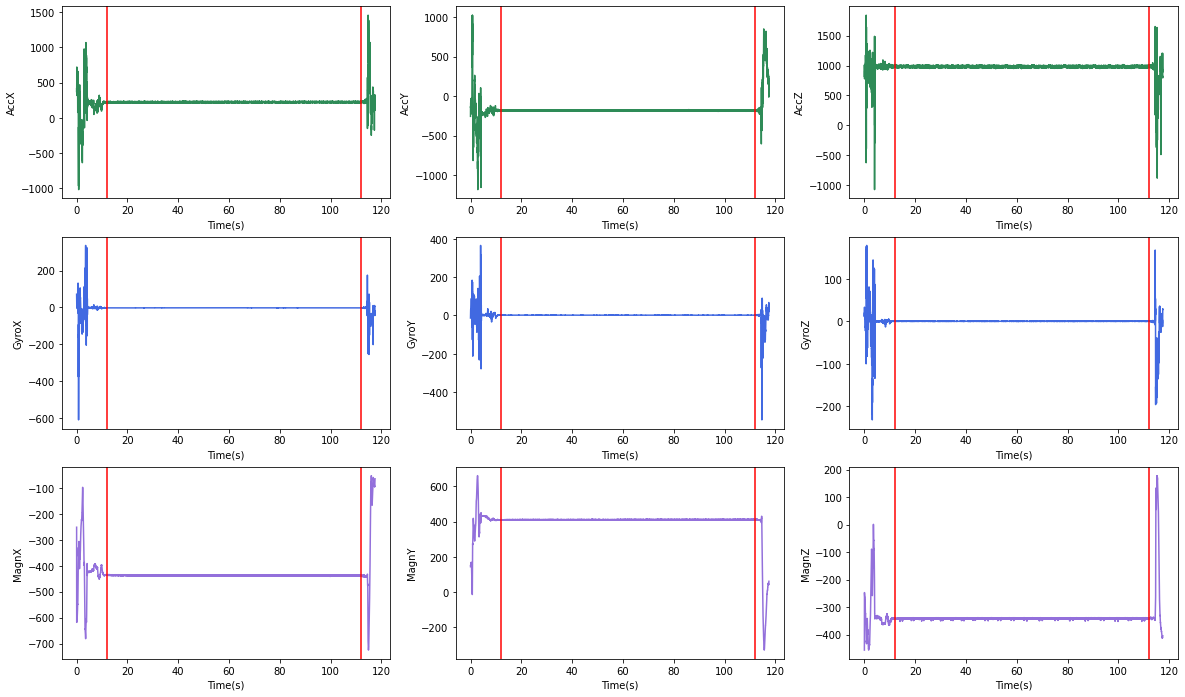

In [10]:
freq_m = 100
x = np.linspace(0, df_m.shape[0] / freq_m, df_m.shape[0])

y_label = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
color = ['seagreen', 'seagreen', 'seagreen', 'royalblue', 'royalblue', 'royalblue', 'mediumpurple', 'mediumpurple', 'mediumpurple']

fig, axs = plt.subplots(3, 3, figsize = (20, 12))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df_m[y_label[i]], color = color[i])
    ax.axvline(x = 12, color = 'r')
    ax.axvline(x = 112, color = 'r')
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    

#### Meaningful data

In [11]:
df2_m = df_m.iloc[1200:11200, :].copy()
x = np.linspace(0, 100, 10000)
df2_m

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1200,210.694,-183.244,974.780,-2.560976,1.951220,0.487805,-436,410,-342
1201,215.513,-178.974,994.544,-2.682927,1.951220,0.243902,-434,409,-341
1202,226.859,-181.292,962.763,-2.439024,1.951220,0.487805,-435,410,-341
1203,223.199,-175.192,975.024,-2.682927,1.585366,0.487805,-436,409,-343
1204,232.959,-177.022,990.457,-2.682927,2.073171,0.487805,-435,410,-342
...,...,...,...,...,...,...,...,...,...
11195,225.456,-186.050,1013.576,-2.682927,1.829268,0.609756,-436,410,-342
11196,224.297,-185.684,986.614,-2.439024,1.585366,0.243902,-437,410,-342
11197,222.406,-180.926,984.601,-2.682927,1.829268,0.487805,-438,412,-342
11198,222.711,-177.144,991.921,-2.439024,1.707317,0.121951,-436,410,-341


### 2.1.3 Calibration

In [12]:
gyro_offset = np.array([-2.804399,1.793105,0.3411708])

acc_cal = np.array([[1.002982,9.415505E-05,0.00434674],
                    [9.04459E-05,1.002731,-0.001444198],
                    [0.004346536,-0.001444751,1.030587]])
acc_offset = np.array([3.602701,-20.96658,54.97186])

magn_cal = np.array([[1.013437,-0.04728858,-0.001861475],
                   [-0.04728862,1.004832,0.008222118],
                   [-0.001861605,0.008221965,0.9439077]])
magn_offset = np.array([-150.4098,74.62431,630.9805])

df2_m[['GyroX','GyroY','GyroZ']] = df2_m[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df2_m[['AccX','AccY','AccZ']] = np.dot(df2_m[['AccX','AccY','AccZ']],acc_cal.T) + acc_offset.T
df2_m[['MagnX','MagnY','MagnZ']] = np.dot(df2_m[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_offset.T

### 2.1.4 Plot meaningful data

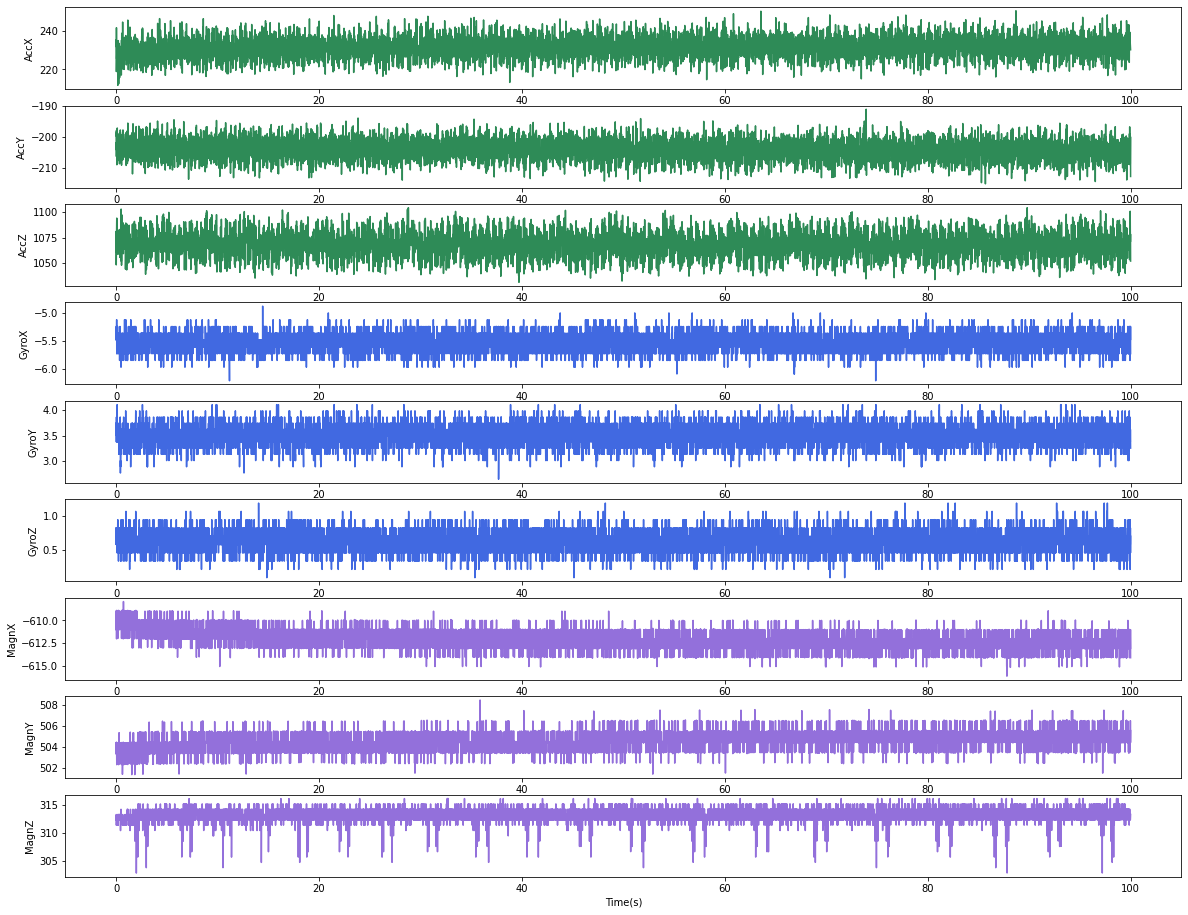

In [13]:
fig, axs = plt.subplots(9, 1, figsize = (20, 16))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df2_m[y_label[i]], color = color[i])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])

## 2.2 Time and frequency analysis
### 2.2.1 Statistical analysis
#### Mean, median, variance, standard deviation, 25th and 75th percentiles

In [14]:
stat = pd.DataFrame({'Mean': df2_m.mean(), 'Median': df2_m.median(), 'Variance': df2_m.var(), 'Standard deviation': df2_m.std(),
    '25% percentile': df2_m.quantile(q = 0.25), '75% percentile': df2_m.quantile(q = 0.75)})
stat

,Mean,Median,Variance,Standard deviation,25% percentile,75% percentile
AccX,231.458241,231.450240,23.727958,4.871135,228.490215,234.484217
AccY,-204.077615,-204.028603,9.240281,3.039783,-206.046750,-202.045358
AccZ,1068.407470,1068.361542,112.769933,10.619319,1062.779152,1074.264520
GyroX,-5.533509,-5.487326,0.025792,0.160599,-5.609277,-5.487326
GyroY,3.511386,3.500422,0.040742,0.201846,3.378471,3.622373
GyroZ,0.634598,0.585073,0.023607,0.153646,0.585073,0.707024
MagnX,-612.114017,-612.035324,1.063936,1.031473,-613.046899,-611.069175
MagnY,504.546851,504.466815,0.640627,0.800392,504.411304,504.569614
MagnZ,313.161223,313.292501,1.291551,1.136464,312.350455,314.228187


#### Correlation coefficients

In [15]:
df2_m_corr = df2_m.corr()
df2_m_corr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,0.082305,-0.052340,-0.006134,-0.000252,-0.006301,-0.063513,0.032620,0.027820
AccY,0.082305,1.000000,0.082217,0.008610,-0.031738,-0.004995,0.052170,-0.038136,-0.017835
AccZ,-0.052340,0.082217,1.000000,0.005579,-0.018462,-0.002105,0.032120,-0.007440,-0.012909
GyroX,-0.006134,0.008610,0.005579,1.000000,-0.032740,0.063888,-0.002951,0.013022,-0.005459
GyroY,-0.000252,-0.031738,-0.018462,-0.032740,1.000000,0.062535,-0.022038,0.004612,-0.000458
GyroZ,-0.006301,-0.004995,-0.002105,0.063888,0.062535,1.000000,0.004949,0.001846,0.012011
MagnX,-0.063513,0.052170,0.032120,-0.002951,-0.022038,0.004949,1.000000,-0.234983,-0.039520
MagnY,0.032620,-0.038136,-0.007440,0.013022,0.004612,0.001846,-0.234983,1.000000,0.051804
MagnZ,0.027820,-0.017835,-0.012909,-0.005459,-0.000458,0.012011,-0.039520,0.051804,1.000000
